# Who feeds the world ? And how wealthy are they ?

## Abstract <a name="abstract"></a>

Our main goal in this project is to find social and economic world-wide relations of countries based on the state of their agricultural sector, using indicators such as imports, exports, production, self-sufficiency, etc. In order to find such indicators, we would like to use the data from the "Global Food & Agriculture Statistics" datasets. First, we would like to produce a map showing which countries "feed the world" i.e. which countries are net-exporting food. That map would contain a slider to show how this evolved over the past fifty years. Then we would like to show countrywise the level of food self-sufficiency i.e. the way a country does not need to trade with other ones in order to feed its population. We will also compare it to nations' economic development and see if some correlations can be found. We will visualize our best findings with several interactive maps and plots.

## Research questions <a name="abstract2"></a>

We would like to work on the following research questions:

- How does the production and consumption of food look like from a geographical point of view ? Which countries are net food exporters or importers? How did this evolve over the last few decades ?
- What's the level of self-sufficiency in food production of individual countries and how does this change over time ?
- Is there a link between the GDP per capita and the agricultural trade balance ? Are countries that are net exporters or importers richer ? Are self-sufficient countries richer ?
- If we find any relations, are they also still valid if we check for specific crops ? Are there some crops that are mostly produced by richer countries, some that are mostly produced by poorer countries?


# Table of contents <a name="toc"></a>


[Abstract](#abstract)

[Research questions](#abstract2) 

[Table of contents](#toc)

1. [Data cleansing and preprocessing](#1)

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
        
    5. [Preprocessing the data set](#1E)
        
    6. [Making one uniformized dataframe](#1F)
        
2. [Data exploration and first observations](#2)
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Prices of food](#2B)  
                
    3. [Structure of international trade](#2C)      
        
    4. [Economic classification of countries](#2D)    
        
3. [Descriptive data analysis](#3)

    1. [Production and consumption of food from a time-space geography point of view](#3A)

    1. [Food self-sufficiency](#3B)

    2. [Giving countries an economic score based on their agricultural features](#3C)

    3. [Food prices stability and agricultural features](#3C)      

4. [Informed plan for next actions](#4)

**External imports:**

In [15]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from ipywidgets import interact
from IPython.display import display

**Auxiliary function imports:**

We have implemented some functions into a dedicated module (file `Milestone_2_scripts.py`) in order to simplify the code and make this notebook more enjoyable to read.

In [16]:
from Milestone_2_scripts import *

**Setup:**

In [17]:
data_folder_path = "./Data/current_FAO/raw_files/"

files = {"Crops production" : "Production_Crops_E_All_Data_(Normalized).csv",
         "Crops trade" : "Trade_Crops_Livestock_E_All_Data_(Normalized).csv", 
         "Population" : "Population_E_All_Data_(Norm).csv",
         "Macroeconomy" : "Macro-Statistics_Key_Indicators_E_All_Data_(Normalized).csv",
         "Livestock production" : "Production_Livestock_E_All_Data_(Normalized).csv",
         "Live animals trade" : "Trade_LiveAnimals_E_All_Data_(Normalized).csv"
        }
interesting_datasets = files.keys()

## 1. Data cleansing and preprocessing <a name="1"></a>

In this part, we will load, explore and clean the dataset in order to remove typing errors, missing information, inaccuracies, and so on.

1. 

    1. [Dataset description](#1A)   
    
    2. [Loading the data set](#1B)
    
    3. [Understanding the data set](#1C)
    
    4. [Cleansing the data set](#1D)
    
        1. [Removing unusefull data](#1Da)         
    
            1. [Extracting GDP from the macroeconomy dataset](#1Dai)
        
        2. [Handling of the missing data](#1Db)
        
            1. [Highlighting the problem](#1Dbi)
            
            2. [Proposed correction](#1Dbii)
        
        3. [Correcting inconsistent data entries](#1Dc)
        
    5. [Preprocessing the data set](#1E)
    
        1. [Converting country names between different naming conventions](#1Ea)
        
        2. [Normalization and log scales](#1Eb)
        
    6. [Making one uniformized dataframe](#1F)

### 1.A. Dataset description <a name="1A"></a>

Our main dataset would be a subset of the "Global Food & Agriculture Statistics" that is found in the proposed datasets list. In this dataset, we have seen that we could work with the production as well as import and export quantities per year and per country. We will add information about countries GDP to this database.

### 1.B. Loading the data set  <a name="1B"></a>

In [18]:
def load_datasets(datasets) :
    df = {}
    for dataset in datasets :
        file_path = data_folder_path + files[dataset]
        df[dataset] = pd.read_csv(file_path, encoding = "ISO-8859-1")
    return df

We load each interresting dataset in the dictionary `df` :

In [19]:
df = load_datasets(interesting_datasets)

### 1.C. Understanding the data set  <a name="1C"></a>

In this part, we will have a first look of the datasets.

In [20]:
def display_df(df, datasets):
    for dataset in datasets :
        display(dataset, df[dataset].sample(5))

In order to see what does the datasets look like, we display a sample of 5 rows for each of them :

In [21]:
display_df(df, interesting_datasets)

'Crops production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
2422613,5502,Melanesia,56,Maize,5419,Yield,2001,2001,hg/ha,32333.0,Fc
1389214,117,Republic of Korea,677,Hops,5510,Production,1981,1981,tonnes,450.0,NaN
1883496,5000,World,203,Bambara beans,5312,Area harvested,1988,1988,ha,63420.0,A
2120625,5206,Caribbean,122,Sweet potatoes,5510,Production,2002,2002,tonnes,635610.0,A
1589272,207,Suriname,122,Sweet potatoes,5525,Seed,1965,1965,tonnes,29.0,Fc


'Crops trade'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
4910525,100,India,550,Currants,5622,Import Value,1993,1993,1000 US$,NaN,M
13044737,5303,Southern Asia,831,Tobacco products nes,5922,Export Value,1974,1974,1000 US$,2318.0,A
12075995,5102,Middle Africa,2027,Meat of Swine,5922,Export Value,2004,2004,1000 US$,32.0,A
578363,11,Austria,1899,Oilseeds,5610,Import Quantity,1964,1964,tonnes,9419.0,A
14353445,5803,Small Island Developing States,748,Peppermint,5622,Import Value,1988,1988,1000 US$,NaN,A


'Population'

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
85222,121,Lebanon,3010,Population - Est. & Proj.,561,Urban population,2058,2058,1000,0.000,XUru
100488,273,Montenegro,3010,Population - Est. & Proj.,513,Total Population - Female,2054,2054,1000,282.722,XU
91072,131,Malaysia,3010,Population - Est. & Proj.,512,Total Population - Male,2026,2026,1000,17134.354,XU
118235,170,Peru,3010,Population - Est. & Proj.,511,Total Population - Both sexes,1995,1995,1000,24038.761,XU
76278,105,Israel,3010,Population - Est. & Proj.,512,Total Population - Male,1997,1997,1000,2775.780,XU


'Macroeconomy'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
453359,209,Swaziland,22075,Value Added (Total Manufacturing),6157,Share of GDP in Local Currency,2006,2006,%,32.863407,Fc
140385,54,Denmark,22075,Value Added (Total Manufacturing),6158,"Share of GDP in Local Currency, 2005 prices",1974,1974,%,15.711578,Fc
235004,106,Italy,22078,Value Added (Manufacture of tobacco products),6114,"Value Local Currency, 2005 prices",1977,1977,millions,NaN,NaN
428667,199,Slovakia,22076,"Value Added (Manufacture of food, beverages an...",6144,"Share of Agriculture, Forestry and Fisheries",2005,2005,%,59.996341,Fc
302739,138,Mexico,22075,Value Added (Total Manufacturing),6155,Annual growth Local Currency,1977,1977,%,39.592136,Fc


'Livestock production'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
80052,147,Namibia,1746,Cattle and Buffaloes,5111,Stocks,1979,1979,Head,2389343.0,A
96249,182,Réunion,2029,Poultry Birds,5112,Stocks,1992,1992,1000 Head,8391.0,A
131018,5100,Africa,946,Buffaloes,5111,Stocks,2006,2006,Head,3937025.0,A
58120,103,Iraq,1057,Chickens,5112,Stocks,2001,2001,1000 Head,28000.0,F
114550,176,Timor-Leste,1096,Horses,5111,Stocks,1965,1965,Head,100000.0,F


'Live animals trade'

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
651363,5803,Small Island Developing States,866,Cattle,5922,Export Value,1973,1973,1000 US$,200.0,A
203308,90,Guinea,1921,"Bovine, Animals",5908,Export Quantity,2000,2000,Head,15000.0,A
625287,5500,Oceania,1079,Turkeys,5622,Import Value,1992,1992,1000 US$,NaN,A
471421,223,Turkey,976,Sheep,5908,Export Quantity,1971,1971,Head,410197.0,NaN
406295,195,Senegal,976,Sheep,5922,Export Value,1977,1977,1000 US$,145.0,F


At first glance, our datasets seem very clean.

Each of our dataset contains a column "Year" and a column that is either named "Area" or "Country". This is a great news for us since we want to do a both geographical and time-related analysis.

The columns "Area" and "Country" both correspond to the country except that the "Area" may contains a group of country (e.g. "Eastern Europe").

### 1.D. Cleansing the data set  <a name="1D"></a>

In this part, we will clean the datasets. The final goal is to produce one uniformized and normalized dataset on which we could work (see [1.F](#1F)).

Such a cleaned dataset may look like this  (in a very simplistic way):

    Country | Year | GDP | Crops production | Livestock production

#### 1.D.a. Removing unusefull data  <a name="1Da"></a>

In this section, we will create dataframes in `df_usefull` which correspond to previous dataframes without the unusefull data.

In [22]:
df_usefull = {}

##### 1.D.a.i. Extracting GDP from the macroeconomy dataset <a name="1Dai"></a>

In [23]:
def extract_GDP(df):
    def selection_GDP(df):
        return df['Item']=='Gross Domestic Product'
    def selection_US_dollars(df):
        return df['Element']=="Value US$"
    def drop_columns(df):
        dropped_colmuns = ["Item Code", "Item", "Element Code", "Element", "Flag", "Year Code", "Unit", "Area Code"]
        return df.drop(columns = dropped_colmuns)
    return drop_columns(df[selection_GDP(df)&selection_US_dollars(df)])

In [24]:
df_usefull["GDP"] = extract_GDP(df["Macroeconomy"])

In [25]:
display(df_usefull["GDP"].sample(5))

,Area,Year,Value
549511,South-Eastern Asia,2003,757290.531908
74002,Burkina Faso,2001,2834.162162
343210,Niger,1996,1912.512510
130347,Czechia,2003,99300.329682
5164,Algeria,2012,209047.479470


##### 1.D.a.ii. ... <a name="1Daii"></a>

TODO crops and livestock, production and trade

##### 1.D.a.iii. Removing areas whiwh are not countries <a name="1Daiii"></a>

TODO

#### 1.D.b. Handling of the missing data  <a name="1Db"></a>

In this section, we will create dataframes in `df_usefull_nomissing` which correspond to previous dataframes without the missing data.

In [32]:
df_usefull_nomissing = {}

##### 1.D.b.i. Highlighting the problem  <a name="1Dbi"></a> 

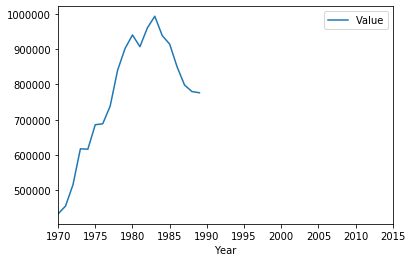

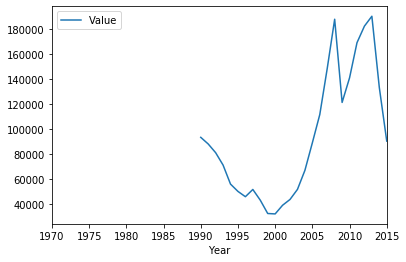

In [33]:
df_usefull["GDP"][df_usefull["GDP"]['Area']=='USSR'].plot(x ='Year', y='Value', kind = 'line')
df_usefull["GDP"][df_usefull["GDP"]['Area']=='Ukraine'].plot(x ='Year', y='Value', kind = 'line')

##### 1.D.b.ii. Proposed correction  <a name="1Dbii"></a> 

TODO (for countries which has appeared, give them value for previous year)
(for example in 1990 : Ukraine is X% of GPD of all countries that appeared from USSR so for 1970->1989 we give Ukraine value X%*GDP(USSR))

#### 1.D.c. Correcting inconsistent data entries  <a name="1Dc"></a>

In this section, we will create dataframes in `df_cleansed` which correspond to previous dataframes where the inconsistent data entries have been corrected.

In [28]:
df_cleansed = {}

### 1.E. Preprocessing the data set  <a name="1E"></a>

In this part, we will finish prepocessing the datasets. More precisely, we will deal with country names and normalizing the features.

#### 1.E.a. Converting country names between different naming conventions  <a name="1Ea"></a>

TODO, explain why (folium) + either Martin or Julien way to do it + show one map

#### 1.E.b. Normalization and log scales  <a name="1Eb"></a>

TODO, explain why (heavy tail, right skewed, power laws) + do it

For instance the distribution of GDP look a bit like a power law.

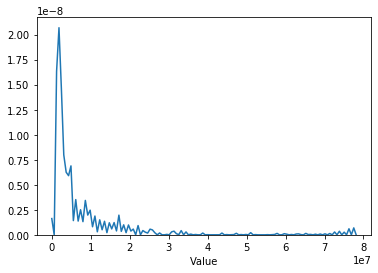

In [38]:
# NEED TO USE df_cleansed INSTEAD OF df_usefull
sns.distplot(df_usefull["GDP"]["Value"], rug=False, hist=False)

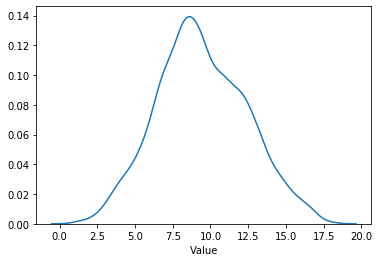

In [37]:
#looks better with log scale
sns.distplot(np.log(df_usefull["GDP"]["Value"]), rug=False, hist=False)

### 1.F. Making one uniformized dataframe  <a name="1F"></a>

In this part, we will make one uniformized dataframe `uni_df` with the following columns.

    Country | Year | GDP | Crops production | Livestock production | Crops importation | Livestock importation | Crops exportation | Livestock exportation
    
In this uniformized dataframe, a tuple `(Country, Year)` uniquely identifies a row.


### 2. Data exploration and first observations  <a name="2"></a>

2. 
        
    1. [Food productions, importations and exportations](#2A)
            
    2. [Prices of food](#2B)      
                
    3. [Structure of international trade](#2C)       
        
    4. [Economic classification of countries](#2D)  
        
In this part, we will explore the dataset with more details. We will first see in more detail the [food productions, importations and exportations](#2A), next examine the [Prices of food](#2B), then study the [structure of international trade](#2C) and finally look at the [economic classification of countries](#2D).

#### 2.A. Food productions, importations and exportations <a name="2A"></a>

2. 
        
    1. 
    
        1. [Crops and livestock production and trade](#2Aa)  
    
            1. [Crops](#2Aai)
            
                1. [Production](#2Aai1)
                
                2. [Importation](#2Aai2)
                
                3. [Exportation](#2Aai3)
    
            2. [Livestock](#2Aaii)  
            
                1. [Production](#2Aaii1)
                
                2. [Importation](#2Aaii2)
                
                3. [Exportation](#2Aaii3)
    
            2. [Globally](#2Aaiii)             
    
        2. [Introducing the concept of food self-sufficiency](#2Ab)
    
            1. [Basic idea](#2Abi)
    
            2. [Formula and computation](#2Abii)
            
TODO

#### 2.B. Prices of food  <a name="2B"></a>

2. 
        
    2. 
    
        1. [Prices](#2Ba) 
    
        2. [Stability of prices](#2Bb)      
        
TODO

#### 2.C. Structure of international trade  <a name="2C"></a>

2.  
                
    3. 
    
        1. [One word about historical context](#2Ca) 
    
        2. [Clusters, circularity and openness rates of international trade](#2Cb)   

TODO

#### 2.D. Economic classification of countries <a name="2D"></a>
TODO

### 3. Descriptive data analysis  <a name="3"></a>

3. 

    1. [Production and consumption of food from a time-space geography point of view](#3A)
        
        1. [Net food exporters or importers](#3Aa)
        
        2. [Evolution over the last few decades](#3Ab)

    1. [Food self-sufficiency](#3B)

    2. [Giving countries an economic score based on their agricultural features](#3C)
        
        1. [Correlation between food trade feature and GDP](#3Ca)
        
        2. [Our own score](#3Cb)
        
        2. [Machine learning model](#3Cc)  

    3. [Food prices stability and agricultural features](#3C)  
    
TODO

### 4. Informed plan for next actions  <a name="4"></a>

TODO